# **Data Science Project: Bank dataset**

In this dataset, we have data on 10.000 (fictitious) customers of a
bank, and want to use the insights to improve the customer retention,
and identify customers at risk of leaving the bank. Finally, we want
to predict which of these customers we will be able to retain over the
next 12 months.

## **Business Questions**
1. Which of the variables have more importance for customer retention?
2. How are these variables related to each other?
3. Which are the top k customers at highest risk of leaving the bank?

## **Analysis**

### Initialization
First of all, we import the libraries we will use, configure some
settings, and load the dataset.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Warning wrapper

def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [3]:
# Notebook display config

pd.options.display.max_rows = 10
sns.set(style="white")

In [4]:
# Load dataset

dataset = pd.read_csv('data.csv')
dataset

,id,last_name,credit_score,country,gender,age,years_customer,balance_euros,num_products,has_credit_card,is_active,salary_euros,retained
0,15634602,Hargrave,619,Switzerland,f,42,2,0.00,1,1,1,101348.88,0
1,15647311,Hill,608,Austria,f,41,1,83807.86,1,0,1,112542.58,1
2,15619304,Onio,502,Switzerland,f,42,8,159660.80,3,1,0,113931.57,0
3,15701354,Boni,699,Switzerland,f,39,1,0.00,2,0,0,93826.63,1
4,15737888,Mitchell,850,Austria,f,43,2,125510.82,1,1,1,79084.10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,Switzerland,m,39,5,0.00,2,1,0,96270.64,1
9996,15569892,Johnstone,516,Switzerland,m,35,10,57369.61,1,1,1,101699.77,1
9997,15584532,Liu,709,Switzerland,f,36,7,0.00,1,0,1,42085.58,0
9998,15682355,Sabbatini,772,Germany,m,42,3,75075.31,2,1,0,92888.52,0


### Dataset cleaning
Now, we will check the consistency of the dataset, looking for not
valid values (NULL, NaN) or duplicates

In [5]:
print("Any Null ?: ", dataset.isnull().values.any())
print("Any NaN ?: ", dataset.isna().values.any())

Any Null ?:  False
Any NaN ?:  False


So, there are no NULL or NaN values that we should care about. However,
duplicates could show up in many different ways. For example, the same
customer could appear with different **ids** but same information due
to some error in the DB, or his **last_name** could had be written
different in two moments. Given that we don't have more information
about the process of getting the data, we will assume that those two
are the most error prone entries, and we will not consider them to find
duplicates.

In [6]:
print(
    "Duplicates ?: ",
    dataset.drop(columns=["id", "last_name"]).duplicated().sum()
    )

Duplicates ?:  0


Now we will also remove some information that we will not need for now
(**id**, **last_name**) and convert some data types.

In [7]:
reduced_data = dataset.drop(columns=['id', 'last_name'])
reduced_data = reduced_data.astype(
    {
        "country": str,
        "gender": str,
        "has_credit_card": bool,
        "is_active": bool,
        "retained": bool
        }
        )
reduced_data

,credit_score,country,gender,age,years_customer,balance_euros,num_products,has_credit_card,is_active,salary_euros,retained
0,619,Switzerland,f,42,2,0.00,1,True,True,101348.88,False
1,608,Austria,f,41,1,83807.86,1,False,True,112542.58,True
2,502,Switzerland,f,42,8,159660.80,3,True,False,113931.57,False
3,699,Switzerland,f,39,1,0.00,2,False,False,93826.63,True
4,850,Austria,f,43,2,125510.82,1,True,True,79084.10,True
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,Switzerland,m,39,5,0.00,2,True,False,96270.64,True
9996,516,Switzerland,m,35,10,57369.61,1,True,True,101699.77,True
9997,709,Switzerland,f,36,7,0.00,1,False,True,42085.58,False
9998,772,Germany,m,42,3,75075.31,2,True,False,92888.52,False


And we will encode the categorical nominal/dichotomous variables using
a one-hot scheme

In [8]:
refactored_data = reduced_data.astype(
    {
        "country": 'category',
        "gender": 'category'
        }
        )
refactored_data = pd.get_dummies(
    refactored_data,
    columns=['country', 'gender']
    )

## **Question 1: Which of the variables have more importance for customer retention?**

### Finding correlation
We will look for correlation in the variables. We will use 3 different
methods of correlation measurements, one that measures linear
correlation (Pearson) and two for a more general correlation coefficient
(Kendall and Spearman)

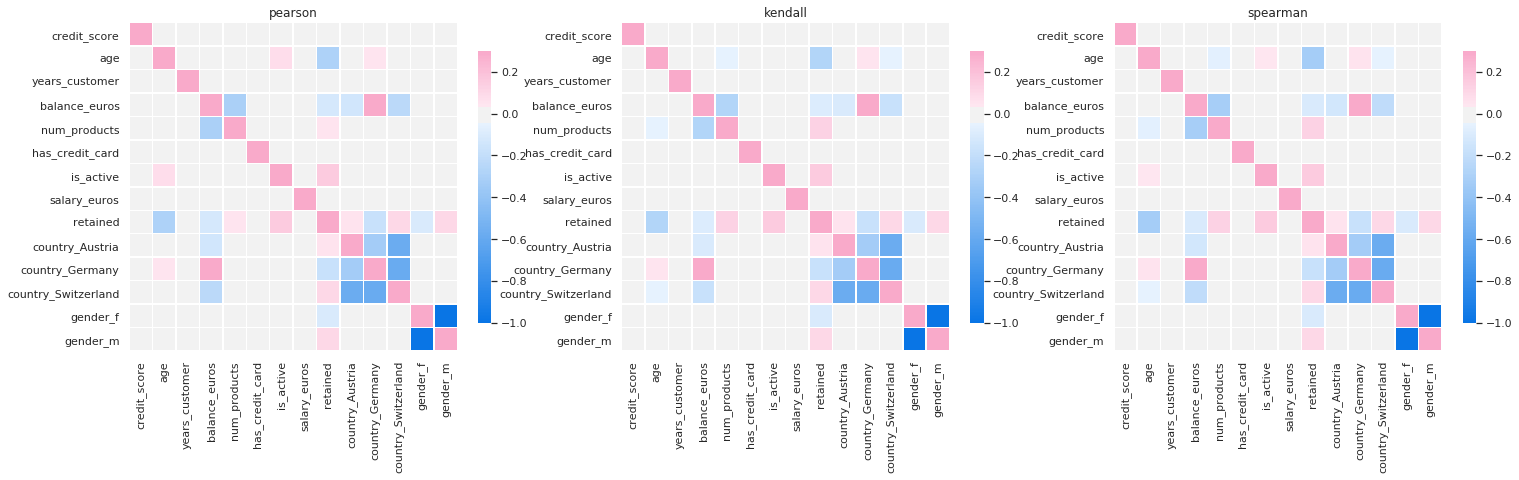

In [9]:
corr_methods = ['pearson', 'kendall', 'spearman']

# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=len(corr_methods), figsize=(25, 10))

for idx, corr_method in enumerate(corr_methods):
    # Compute the correlation matrix
    corr = refactored_data.corr(method=corr_method)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(255, 0, s=99, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr, cmap=cmap, vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5},
        ax=axes[idx]
        )
    axes[idx].set_title(corr_method)

Looking at the heatmaps, we see that we can avoid using some of the
variables for getting some insights, as they don't give much insight.
We can **discard the following variables**:
1. **credit_score**
2. **years_customer**
3. **has_credit_card**
4. **salary_euros**

In [10]:
discard_variables = [
    'credit_score',
    'years_customer',
    'has_credit_card',
    'salary_euros'
    ]
reduced_data = reduced_data.drop(columns=discard_variables)
refactored_data = refactored_data.drop(columns=discard_variables)

It is important to remember that correlation does not imply causation.
That means that, given that we find some kind of correlation between
two variables, we still do not know which one causes the other, or if
there is a bidirectional causation, or if there is some extra variable
that affects both of them (and they do not cause each other), or if
these two variables cause change in another one, or if one of them
causes change in an extra variable that causes change in the second
one, or finally, if there is no connection and it is mere coincidence.

https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation#General_pattern

So it would be our duty to understand which of these relationship have
the variables, given that we now the nature of some of them, and that
we could make some experiments (which go beyond the scope of this
analysis).

## **Question 2: How are these variables related to each other?**

Now we will make some plots to try to understand the relationships
between some of the given variables.

#### **age VS retained VS is_active VS num_products**
We will start with this 4 variables, as we see they have some kind of
relationship between them. We will use violin plots, as they are good
to see the difference between distribution estimations.

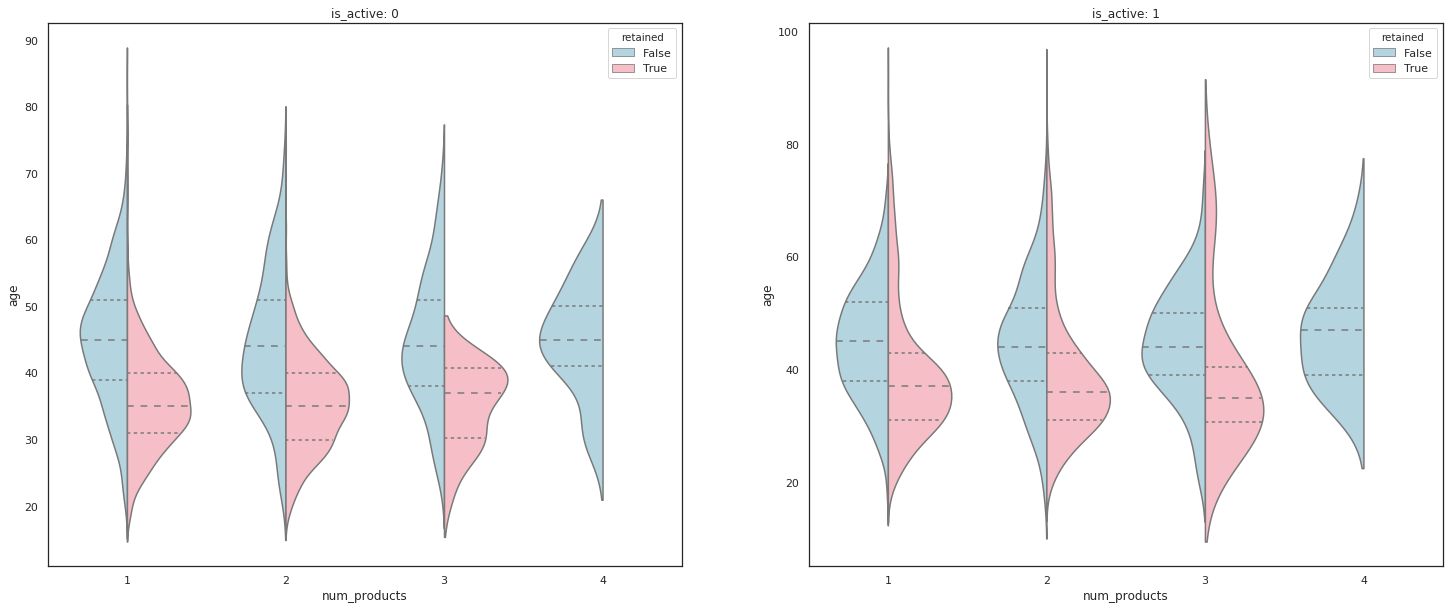

In [11]:
# Age vs retained vs is_active vs num_products
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
for idx in range(2):
    sns.violinplot(
        "num_products", "age", hue="retained",
        data=reduced_data[reduced_data['is_active'] == bool(idx)],
        split=True, inner="quartile", palette=["lightblue", "lightpink"],
        ax=axes[idx]
    )
    axes[idx].set_title("is_active: "+str(idx))

So we can get many conclutions from the previous plots. First of all,
we see that customers with 4 products are not retained, no matter the
other variables. Also, retained customers are in general younger than
not retained customers. Furthermore, when customers are active, they
tend to be retained even being older.

#### **age VS country**
We left the 'country' variable out of the last plot, so let's see a
kde plot of the age of customers for different countries.

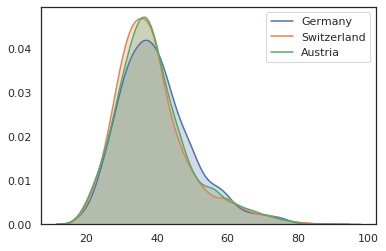

In [12]:
# Age vs country
for country in ['Germany', 'Switzerland', 'Austria']:
    sns.kdeplot(
        refactored_data['age'][refactored_data['country_'+country] == True],
        shade=True, label=country
    )

German customers have just a little more sparse age range that Swiss
and Austrians.

#### **balance_euros VS num_products VS retained VS country**
Now we will analyse these variables, as the heatmap plot showed some
correlation between them. Again, we will use violin plots.

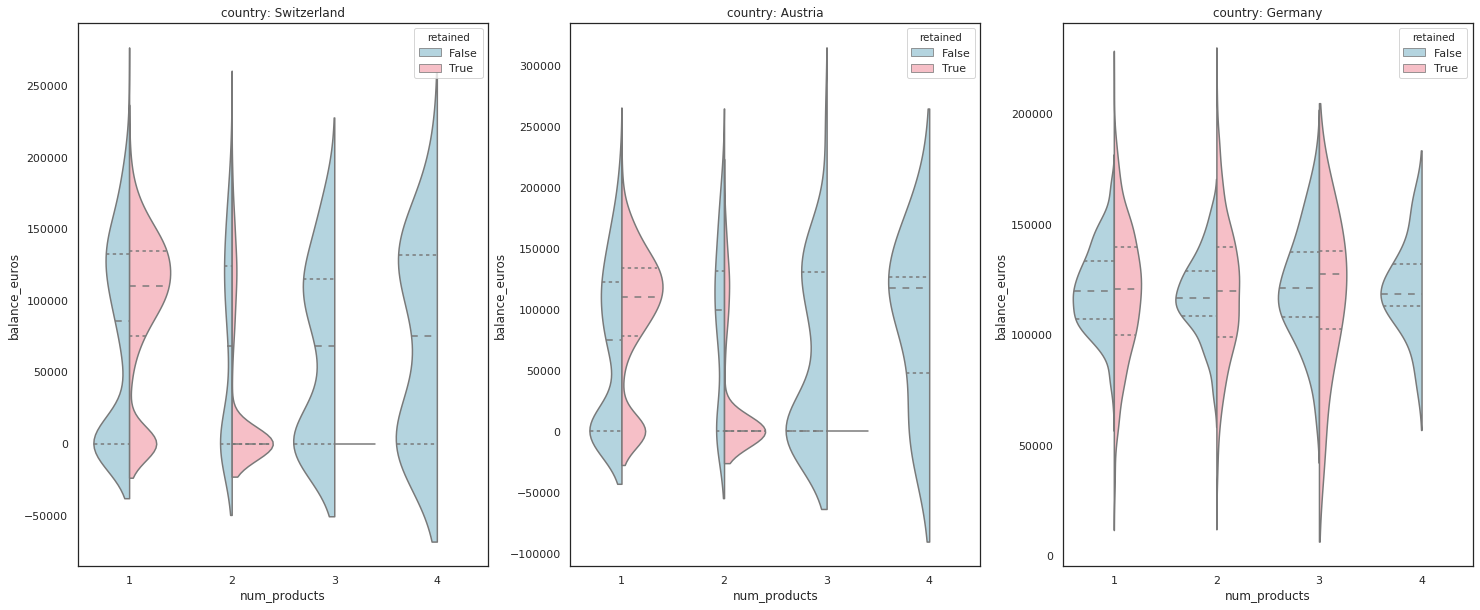

In [13]:
# balance_euros vs num_products vs retained vs country
countries_list = reduced_data.country.unique()
f, axes = plt.subplots(nrows=1, ncols=len(countries_list), figsize=(25, 10))
for idx, country in enumerate(countries_list):
    sns.violinplot(
        "num_products", "balance_euros", hue="retained",
        data=reduced_data[reduced_data['country'] == countries_list[idx]],
        split=True, inner="quartile", palette=["lightblue", "lightpink"],
        ax=axes[idx]
    )
    axes[idx].set_title("country: "+str(country))

Again, many conclutions arrive from the graphs. We have already seen
that customers with 4 products are not retained. But now we see that
for Switzerland and Austria, also customers with 3 products are not
retained. But we also see some odd peak around 0 euros balance for
these countries, which does not happen for Germany. Knowing that this
plots are KDE, we could think that what is happening is that there are
actually customers with exactly 0 euros balance for Switzerland and
Austria, and not for Germany. So let's make one more suitable plot this
case, using a histogram, that uses bins instead of kernels, so we can
check our theory.

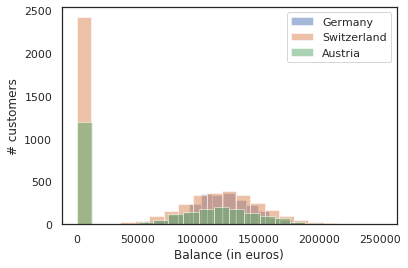

In [14]:
# balance_euros vs country
fig, ax = plt.subplots()
for country in ['Germany', 'Switzerland', 'Austria']:
    ax.hist(
        refactored_data[
            'balance_euros'
            ][
                refactored_data['country_'+country] == True
                ],
        bins=20, alpha=0.5,
        label=country
    )
ax.legend(loc='upper right')
ax.set_xlabel('Balance (in euros)')
ax.set_ylabel('# customers')
plt.show()

In fact, we see that there are customers with 0 euros balance for
Switzerland and Austria, and not for Germany. Other thing that we can
see here and we couldn't see using KDE's, is that there are more
customers in Switzerland than in Austria and Germany. We can add a bar
plot to see this more clearly, and take advante od it, adding the
'retained' variable to the plot.

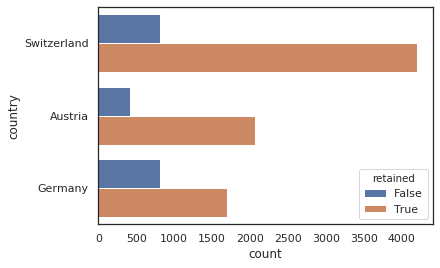

In [15]:
# country vs retained
ax = sns.countplot(y="country", hue="retained", data=reduced_data)

The plot not only shows that there are more customers in Switzerland
than in Austria and Germany, but also that customers from Germany have
a lower retain factor than the rest.

#### **gender vs retained**
The last variable that we will analyze is gender, which we saw before
that had correlation with the retain factor. As they are just two
variables, we will be using again a bar plot.

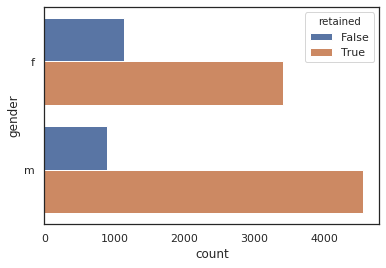

In [16]:
# retained vs gender
ax = sns.countplot(y="gender", hue="retained", data=reduced_data)

We see that males have a greater retain factor. It also seems that
there are more male customers than female customers, but as the bars
are splitted, we can not be 100% sure. So we will add one last plot
just for the gender distribution.

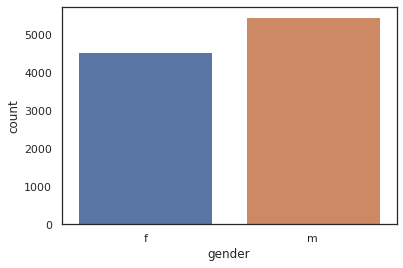

In [17]:
# retained vs gender
ax = sns.countplot(x="gender", data=reduced_data)

## Question 3: Which are the top k customers at highest risk of leaving the bank?

For this question will train different classification models, using
Logistic Regression, Random Forest, SVM and MultLayer Perceptron
classifiers. We will be using grid-search with cross-validation for
hyperparameters tuning, and test-set for computing the final model
scores.

### Initialization
We will be using the scikit-learn library, as it is simpler and more
general machine learning library than others (Keras, Tensorflow,
PyTorch) and we don't need to use deep learning.

In [18]:
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    learning_curve,
    validation_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    balanced_accuracy_score,
    average_precision_score
)
from sklearn.metrics import precision_recall_curve, roc_curve

from sklearn.calibration import CalibratedClassifierCV

from inspect import signature

In [19]:
# Get data and labels
labels = refactored_data["retained"]
data = refactored_data.drop(columns='retained')

### Labels distribution
We have to take into account if we are using a balanced or an
imbalanced dataset, as the metrics for both cases are different. For
balanced datasets, we can use the accuracy for a score of the model,
but for imbalanced dataset we should use other score/s (like balanced
accuracy for a general score, and precission and recall for classes
scores) and even some dataset handling techniques, such as unequal
label weights, under/over sampling methods (sometimes combined with
data augmentation), cost-sensitive training, and so on.

In [20]:
# Labels distribution
print(
    "Labels distribution:\n",
    (labels.value_counts()/len(labels)*100).map('{:.2f}'.format)
    )

Labels distribution:
 True     79.63
False    20.37
Name: retained, dtype: object


We see that there are much more True labels than False ones. So for
now we will just take this into account for the score metrics and
apply class_weight for the training process when possible.

We will first split the dataset into train and test sub-sets, using
the stratify option because of the imbalanced dataset, so to be sure
we keep the same distribution for both tran and test dataset.

The test set will be used just for computing the final model metrics.
This final model will be selected from a range of different models
trained with hyperparameters grid-search and cross-validation, where
we will again split our train sub-set into a (new)train-set and
eval-set.

https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Nested_cross-validation

In [21]:
# Split into Train, Validation and Test set
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    test_size=0.15,
    random_state=1,
    shuffle=True,
    stratify=labels
)

In [22]:
# Train and Test Labels distribution
print(
    "Train distribution:\n",
    (y_train.value_counts()/len(y_train)*100).map('{:.2f}'.format)
    )
print(
    "\nTest distribution:\n",
    (y_test.value_counts()/len(y_test)*100).map('{:.2f}'.format)
    )

Train distribution:
 True     79.64
False    20.36
Name: retained, dtype: object

Test distribution:
 True     79.60
False    20.40
Name: retained, dtype: object


### Models

First, we define some helper functions and variables that we will be
using later.

In [23]:
# Helper functions and variables

def print_grid_search_metrics(grid_lr):
    print("Best parameters set found: ", grid_lr.best_params_)
    print(
        "\nTrain Balanced Accuracy: %0.2f (+/-%0.02f)" % (
            grid_lr.cv_results_['mean_train_score'][grid_lr.best_index_],
            grid_lr.cv_results_['std_train_score'][grid_lr.best_index_] * 2
            )
            )
    print(
        "Dev Balanced Accuracy: %0.2f (+/-%0.02f)" % (
            grid_lr.cv_results_['mean_test_score'][grid_lr.best_index_],
            grid_lr.cv_results_['std_test_score'][grid_lr.best_index_] * 2
            )
            )


StratifiedKFolds = 5

#### Logistic Regression

In [24]:
# Logistic Regression

params = dict(
    C=list(range(1, 110, 10)),
    solver=['liblinear', 'lbfgs'],
    max_iter=[10, 100, 500, 1000]
)

# Create NN grid search
grid_lr = GridSearchCV(
    estimator=LogisticRegression(
        random_state=1,
        class_weight='balanced'
        ),
    param_grid=params,
    scoring='balanced_accuracy',
    refit='balanced_accuracy',
    cv=StratifiedKFolds,
    return_train_score=True,
    n_jobs=4,
    verbose=0
    )

# Train
grid_lr.fit(X_train, y_train)

# Show metrics
print_grid_search_metrics(grid_lr)

Best parameters set found:  {'C': 11, 'max_iter': 100, 'solver': 'liblinear'}

Train Balanced Accuracy: 0.69 (+/-0.01)
Dev Balanced Accuracy: 0.69 (+/-0.02)


So the best model trained with random forest is the one with this
parameters:

{'C': 11, 'max_iter': 100, 'solver': 'liblinear'}

Given that the C limits were between 1 and 110, and the max_iter
limits between 10 and 1000, we could think that we have found a local
minimum between these limits and don't need to train more models
beyond them (although this is not strictly correct and not even the
best possible model, as there could be a model with better score
beyond these limits, or even in between them).

Even if we used a grid search for estimating the best hyperparameters
of the model, and used K Folds for the Cross-Validation, we
used a fix number of train/dev samples. But what if this split ratio
could change our performance? For example, we could use more train
samples and less dev samples if we were underfitting (with the risk of
having a dev metric with lower precission), or the other way if we
were over-fitting (with the risk of starting having lower accuracies).
So now we will keep the models with the best parameters, but plot a
learning curve, to see if we could benefit from adding more training
data, and whether the estimator suffers more from a variance error or
a bias error.

In [25]:
# taken (but modified to add scoring parameter) from:
# https://scikit-learn.org/stable/_downloads/plot_learning_curve.py
def plot_learning_curve(estimator, title, X, y, scoring=None, ylim=None,
                        cv=None, n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs,
        train_sizes=train_sizes
        )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/max/miniconda3/envs/data-science/lib/python3.8/site-packages/matplotlib/pyplot.py'>

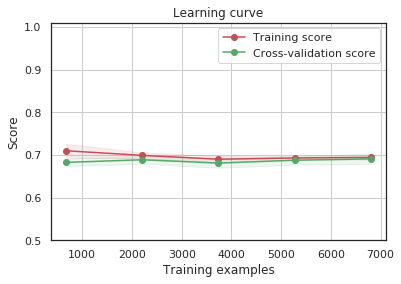

In [26]:
plot_learning_curve(
    grid_lr.best_estimator_,
    "Learning curve",
    X_train, y_train,
    scoring='balanced_accuracy',
    ylim=(0.5, 1.01),
    cv=5,
    n_jobs=4
    )

Both the validation score and the training score converge to a value
(around 0.7) with increasing size of the training set, therefore we
will not benefit much from more training data. We will probably have
to use an estimator or a parametrization of the current estimator that
can learn more complex concepts (i.e. has a lower bias).

#### Random Forest

In [27]:
# Random Forest

params = dict(
    n_estimators=list(range(10, 100, 10)),
    max_depth=list(range(2, 10, 1))
    )

# Create RandomForest grid search
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=1,
        class_weight='balanced'
        ),
    param_grid=params,
    scoring='balanced_accuracy',
    refit='balanced_accuracy',
    cv=StratifiedKFolds,
    return_train_score=True,
    n_jobs=4,
    verbose=0
    )

# Train
grid_rf.fit(X_train, y_train)

# Show metrics
print_grid_search_metrics(grid_rf)

Best parameters set found:  {'max_depth': 7, 'n_estimators': 90}

Train Balanced Accuracy: 0.81 (+/-0.00)
Dev Balanced Accuracy: 0.78 (+/-0.01)


So the best model trained with random forest is the one with this
parameters:

{'max_depth': 6, 'n_estimators': 30}

Again, given that the n_estimators limits were between 10 and 100, and
the max_depth limits between 2 and 10, we could think that we have
found a local minimum between these limits and don't need to train
more models beyond them.

Let's plot the learning curve.

<module 'matplotlib.pyplot' from '/home/max/miniconda3/envs/data-science/lib/python3.8/site-packages/matplotlib/pyplot.py'>

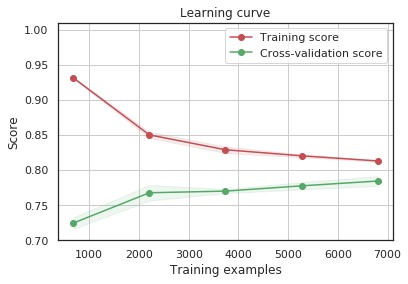

In [28]:
plot_learning_curve(
    grid_rf.best_estimator_,
    "Learning curve",
    X_train, y_train,
    scoring='balanced_accuracy',
    ylim=(0.7, 1.01),
    cv=5,
    n_jobs=4
    )

Both the validation score and the training score converge to a value
(around 0.79) with increasing size of the training set, therefore we
will not benefit much from more training data. We will probably have
to use an estimator or a parametrization of the current estimator that
can learn more complex concepts (i.e. has a lower bias).

#### SVM

In [29]:
# SVM

params = dict(
    C=list(range(1, 110, 20)))

# Create SVM grid search
grid_svm = GridSearchCV(
    estimator=svm.SVC(
        kernel='rbf',
        gamma='auto',
        class_weight='balanced'
        ),
    param_grid=params,
    scoring='balanced_accuracy',
    refit='balanced_accuracy',
    cv=StratifiedKFolds,
    return_train_score=True,
    n_jobs=4,
    verbose=0
    )

# Train
grid_svm.fit(X_train, y_train)

# Show metrics
print_grid_search_metrics(grid_svm)

Best parameters set found:  {'C': 21}

Train Balanced Accuracy: 0.96 (+/-0.00)
Dev Balanced Accuracy: 0.56 (+/-0.02)


This time, as there are less models, let's see all the scores from the
grid:

In [30]:
print("Grid scores on development set:")
print()
means = grid_svm.cv_results_['mean_test_score']
stds = grid_svm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_svm.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Grid scores on development set:

0.550 (+/-0.022) for {'C': 1}
0.561 (+/-0.018) for {'C': 21}
0.560 (+/-0.021) for {'C': 41}
0.560 (+/-0.022) for {'C': 61}
0.559 (+/-0.021) for {'C': 81}
0.559 (+/-0.020) for {'C': 101}



We plot again the learning curve

<module 'matplotlib.pyplot' from '/home/max/miniconda3/envs/data-science/lib/python3.8/site-packages/matplotlib/pyplot.py'>

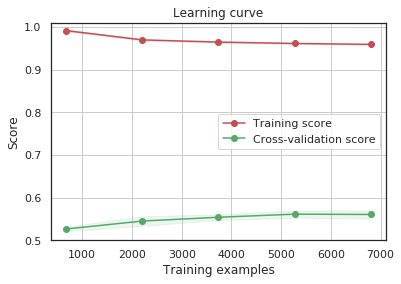

In [31]:
plot_learning_curve(
    grid_svm.best_estimator_,
    "Learning curve",
    X_train, y_train,
    scoring='balanced_accuracy',
    ylim=(0.5, 1.01),
    cv=5,
    n_jobs=4
    )

This time, as the training score is much greater than the validation
score for the maximum number of training samples, means than the model
is more complex, and adding more training samples will most likely
increase generalization. We could also try reducing the complexity of
the model changing its parameters.

We can see that we have used just one parameter in the grid-search. So
we could instead use a validation curve for this purpose, which would
also plot the values.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn.model_selection.validation_curve

In [32]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range,
                          scoring=None, ylim=None, cv=None, n_jobs=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : string
        Name of the parameter that will be varied.

    param_range : array-like, shape (n_values,)
        The values of the parameter that will be evaluated.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or a scorer callable /
        object function with signature scorer(estimator, X, y).

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    """

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    if ylim is not None:
        plt.ylim(*ylim)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

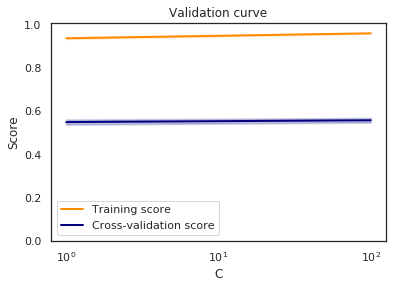

In [33]:
plot_validation_curve(
    estimator=grid_svm.best_estimator_,
    title="Validation curve",
    X=X_train, y=y_train,
    param_name="C",
    param_range=(1, 100),
    scoring='balanced_accuracy',
    ylim=(0, 1.01),
    cv=5,
    n_jobs=4
    )

As we saw with the scores from the grid-search, all the models (each
of them with different C value) are pretty similar.

#### Multi Layer Perceptron (NN)

In [34]:
# NN

params = dict(
    hidden_layer_sizes=[(50,), (50, 100), (20, 40, 20)],
    activation=['logistic', 'tanh', 'relu'],
    solver=['lbfgs', 'adam'],
    max_iter=[10, 100, 500]
)

# Create NN grid search
grid_mlp = GridSearchCV(
    estimator=MLPClassifier(random_state=1),
    param_grid=params,
    scoring='balanced_accuracy',
    refit='balanced_accuracy',
    cv=StratifiedKFolds,
    return_train_score=True,
    n_jobs=4,
    verbose=0
    )

# Train
grid_mlp.fit(X_train, y_train)

# Show metrics
print_grid_search_metrics(grid_mlp)

Best parameters set found:  {'activation': 'relu', 'hidden_layer_sizes': (50, 100), 'max_iter': 500, 'solver': 'adam'}

Train Balanced Accuracy: 0.62 (+/-0.03)
Dev Balanced Accuracy: 0.62 (+/-0.02)


<module 'matplotlib.pyplot' from '/home/max/miniconda3/envs/data-science/lib/python3.8/site-packages/matplotlib/pyplot.py'>

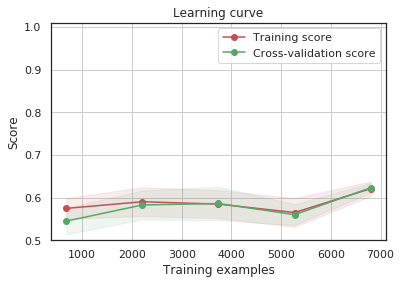

In [35]:
plot_learning_curve(
    grid_mlp.best_estimator_,
    "Learning curve",
    X_train, y_train,
    scoring='balanced_accuracy',
    ylim=(0.5, 1.01),
    cv=5,
    n_jobs=4
    )

Both the validation score and the training are increasing with the
size of the training set, therefore we will probably benefit from more
training data or more epochs. However, we will now select our current
best model so we can continue with the rest of the challenge.

### Choose the best model, calibrate it and get test results
Finally we choose the best classifier, calibrate it to have also good
scores, and finally predict with the test set and show results.

#### Best model

In [48]:
# Choose best classifier
df = pd.DataFrame(
    {
        'name': ["Logistic Regression", "Random Forest", "SVM", "NN"],
        'model': [
            grid_lr.best_estimator_,
            grid_rf.best_estimator_,
            grid_svm.best_estimator_,
            grid_mlp.best_estimator_
            ],
        'score': [
            grid_lr.best_score_,
            grid_rf.best_score_,
            grid_svm.best_score_,
            grid_mlp.best_score_
            ]
            }
            )
max_idx = df['score'].argmax()

print("Chosen classifier: ", df.loc[max_idx, 'name'])
print("Cross validation Accuracy: %0.2f" % df.loc[max_idx, 'score'])
clf = df.loc[max_idx, 'model']

Chosen classifier:  Random Forest
Cross validation Accuracy: 0.78


In [49]:
clf = grid_rf.best_estimator_

#### Calibration

Confidence calibration refers to predicting probability estimates
(scores) representative of the true  correctness likelihood. Even if
this is a problem more related to modern neural networks and Deep
Learning, is good to check if this scores are correct for any ML model.
[This paper](https://arxiv.org/pdf/1706.04599.pdf) describes the
problem and today known solutions very well. A shorter explanation can
be found [here](https://scikit-learn.org/stable/modules/calibration.html).
Here we will be using the [scikit-learn class](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html)
for calibration.

In [50]:
cal_clf = CalibratedClassifierCV(
        base_estimator=clf, method='sigmoid', cv=StratifiedKFolds
        )
cal_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=7,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                            

#### Test results

In [53]:
print("Classification report:\n")
y_true, y_pred = y_test, cal_clf.predict(X_test)
print(classification_report(y_true, y_pred))

Classification report:

              precision    recall  f1-score   support

       False       0.70      0.53      0.60       306
        True       0.89      0.94      0.91      1194

    accuracy                           0.86      1500
   macro avg       0.79      0.73      0.76      1500
weighted avg       0.85      0.86      0.85      1500



First of all, we see that both precision and recall are higher for
True label values (remember that the label was the 'retained'
variable). That sounds logic since we had an imbalanced dataset and we
just used class weights to supply that. It might also be just easier
to detect retained customers given some input parameters, even if we
trained with a balanced dataset.

A precision value of 0.49 for the False label tells us that if we take
all the customers from the test set that the model said wouldn't be
retained, almost half of them would actually had been retained.
A recall value of 0.75 for the False label tells us that if we take
all the customers from the test set that wouldn't actually be retained,
3 out of 4 of them would had been right estimated by the model.
The F1 score is the harmonic mean of the precision and recall.

A macro-average will compute the metric independently for each class
and then take the average (hence treating all classes equally). For
example, the macro avg of the precision is 0.71, because is the
average of 0.49 and 0.92.
The weighted avg calculates metrics for each label, and find their
average weighted by support (the number of true instances for each
label). This alters ‘macro’ to account for label imbalance. In this
case, for the precision, is given by:
(0.49 * 306 + 0.92 * 1194) / 1500

In [54]:
print(
    "Test balanced accuracy: %0.2f\n" %
    balanced_accuracy_score(y_true, y_pred)
    )

Test balanced accuracy: 0.73



The balanced accuracy is defined as the average of recall obtained on
each class. So we have the same value as in the classification report.

The ROC curve is created by plotting the true positive rate (TPR)
against the false positive rate (FPR) at various threshold settings.
The AUC is the area under the ROC curve. This score gives us a good
idea of how well the model performances, indicating how well the
probabilities from the positive classes are separated from the
negative classes.

Average precision score: 0.88


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

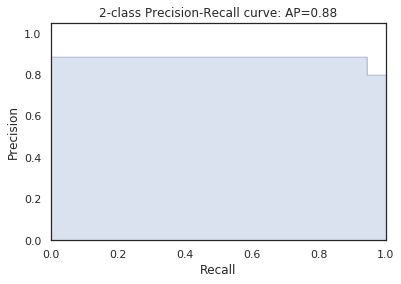

In [55]:
average_precision = average_precision_score(y_test, y_pred)

print('Average precision score: {0:0.2f}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_true, y_pred)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    '2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision)
    )

ROC-AUC score: 0.73



Text(0.5, 1.0, '2-class ROC curve: AUC-ROC=0.73')

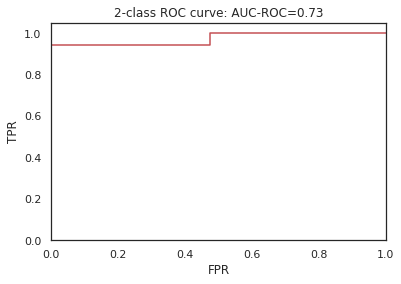

In [56]:
roc_auc = roc_auc_score(y_true, y_pred)

print("ROC-AUC score: %0.2f\n" % roc_auc)

fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.step(fpr, tpr, color='r', alpha=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class ROC curve: AUC-ROC={0:0.2f}'.format(roc_auc))

ROC Curves summarize the trade-off between the true positive rate and
false positive rate for a predictive model using different probability
thresholds.
Precision-Recall curves summarize the trade-off between the true
positive rate and the positive predictive value for a predictive model
using different probability thresholds.
ROC curves are appropriate when the observations are balanced between
each class, whereas precision-recall curves are appropriate for
imbalanced datasets.

## Top k customers at highest risk of leaving the bank

Customers at highest risk of leaving are those who are still retained
(their label in the dataset is True) but their probability of being
retained (given by the best model we have) is lowest.

In [57]:
probas = cal_clf.predict_proba(data[labels == True])
probas

array([[0.14405827, 0.85594173],
       [0.06708209, 0.93291791],
       [0.2488211 , 0.7511789 ],
       ...,
       [0.02876506, 0.97123494],
       [0.0608256 , 0.9391744 ],
       [0.10598655, 0.89401345]])

Now we check the order of labels in the probability columns:

In [58]:
cal_clf.classes_

array([False,  True])

So we need to sort the probabilities:

In [59]:
indexes = np.argsort(probas[:, 1], axis=0)

In [60]:
ordered_leaving_customers = dataset.iloc[indexes, 0:2]
ordered_leaving_customers

,id,last_name
246,15685500,Glazkov
3865,15729435,McKenzie
6192,15731781,Onyemachukwu
480,15695585,Atkins
1757,15704763,Kozlova
...,...,...
6726,15633213,Rizzo
19,15568982,Hao
4518,15642991,Tung
5756,15706217,Kao


Now we just define k and keep the top k customers at highest risk of
leaving

In [61]:
k = 5
ordered_leaving_customers.iloc[range(k), :]

,id,last_name
246,15685500,Glazkov
3865,15729435,McKenzie
6192,15731781,Onyemachukwu
480,15695585,Atkins
1757,15704763,Kozlova


We could also make k a dependent variable, and use, for example, a
threshold of the probability for being kept as parameter:

In [62]:
th = 0.2
sorted_probas = np.sort(probas[:, 1], axis=0)
ordered_leaving_customers[sorted_probas < th]

,id,last_name
246,15685500,Glazkov
3865,15729435,McKenzie
6192,15731781,Onyemachukwu
480,15695585,Atkins
1757,15704763,Kozlova
...,...,...
3571,15790336,Tokareva
1229,15607598,Muravyov
3836,15602797,Okwudilichukwu
5317,15791114,Yegorova
